### SELF-SUPERVISED DENOISING: PART SIX
# Automated blind-mask design with eXplainable AI (XAI): Field Data Application
### _Authors: [Claire Birnie](https://cebirnie92.github.io/) and [Matteo Ravasi](https://mrava87.github.io), KAUST_


---------------


**The grand finale**

This is the sixth, and final, tutorial in our self-supervised seismic denoising tutorial series. In this tutorial we put all the elements from the earlier tutorials together (blind-spot, blind-mask and XAI mask design) to implement a fully automated self-supervised coherent noise suppression procedure to field data.

The tutorial notebooks were originally designed to supplement the course slides. However, it should still be easy to follow provided you have read the reference paper and understood the key concepts.

## Tutorial Objectives

On completion of this tutorial, you will have denoised a field seismic section using the 


## Prior Requisites:
Complete tutorial 5 and copy-paste your corruption, training and evaluate functions into ssdn_functions.py. If you have not completed tutorial 5, at the stages in this tutorial where those functions are required you will be prompted to copy-paste the skeleton code from tutorial 1 and complete it. As a last resort, copy the pre-written functions from the solutions directory. Writing the code is a great way to ensure you fully understand the methodology therefore we do not recommend copy-pasting from the solutions directory.

## Reference Paper:
Birnie, C. and Ravasi, M., 2024. Explainable artificial intelligence‐driven mask design for self‐supervised seismic denoising. Geophysical Prospecting.

[[Paper Link]](https://doi.org/10.1111/1365-2478.13480)

## Key Concepts Recap
#### _N2V: Random Noise Suppression_
In this series of tutorials, we implement the Noise2Void methodology of [Krull et al., [2019]](https://openaccess.thecvf.com/content_CVPR_2019/papers/Krull_Noise2Void_-_Learning_Denoising_From_Single_Noisy_Images_CVPR_2019_paper.pdf) for self-supervised denoising using blind-spot networks. The methodology involves performing a pre-processing step that identifies a number of 'active' pixels and replaces their original noisy values with the value of a neighbouring pixel. This processed data becomes the input to the neural network with the original noisy image being the network's target. However, unlike in most NN applications, the loss is not computed across the full predicted image, but only at the active pixel locations. Under the assumption of i.i.d. noise, the network cannot predict the noise element of the active pixels' original values and, therefore, the network only learns to recreate the signal element, resulting in a denoised image.  

#### _StructN2V: Coherent Noise Suppression_
N2V requires noise to be independent, however this is a rare occurrence. [Broaddus et al., [2020]](https://ieeexplore.ieee.org/document/9098336) proposed StructN2V to extend the blind-spot methodology to coherent noise suppression. To do so, first, the raw data is evaluated to determine the relationship between noise elements across pixels. This analysis is used to build a noise mask that is designed to hide any pixels which exhibit coherency between their noise elements and the noise of the central pixel. Once the mask is designed, active pixels are selected (like in the original N2V methodology) however now not only is the central pixel's value changed, as is all pixels that fall within the noise mask. As the mask covers neighbouring pixels, the  values used for corruption are typically drawn from a predefined distribution.  Corrupting all pixels within the mask region ensures the input to the network has no useable information for predicting the noise component of the central pixels. As before, the loss is only computed at the active pixels locations. In theory, the network learns to use pixels out with the masked area to recreate the central pixel's value.


#### _Jacobian Analysis: eXplainable AI_
For bias-free CNNs, the relationship between a single input and output is **locally linear**, where the output forms the matrix multiplication between the input and the Jacobian matrix of the neural network. As such, to determine the strength input pixels have on a single output pixel's predicted value, one can compute and extract the corresponding row of the Jacobian matrix. Knowledge of heavily contributing pixels can be used to automate (or guide) the blind-mask design. 


***

In [1]:
# Import necessary basic packages
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from tqdm import tqdm 

# Import necessary torch packages
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader 

# Import our pre-made functions which will keep the notebook concise
# These functions are independent to the blindspot application however important for the data handling and 
# network creation/initialisation
from unet import UNet
import tutorial_utils as tu
import plotting_utils as pu


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
# Some general plotting parameters so we don't need to keep adding them later on
cmap='RdBu'
vmin = -0.25
vmax = 0.25

# For reproducibility purposes we set random, numpy and torch seeds
tu.set_seed(42) 

True

***

# BLIND-MASK NETWORK TRAINING

## Step One - Data loading

In this example we are going to use a field post-stack depth migrated image, originally obtained from the Madagascar repo, that is commonly used for benchmarking random noise suppression procedure. The data is available  from [this One Drive](https://drive.google.com/drive/folders/1AovokXsyo6VYxfzLZ2gpvVHLadh5wuN1?usp=sharing).

(696, 300)


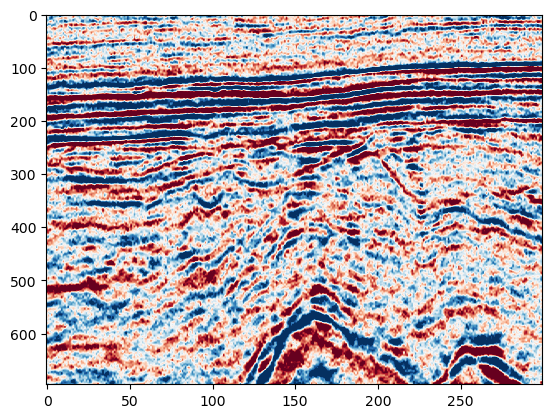

In [3]:
field_data = np.load("../data/FieldExample_RandomNoise.npy")[:696,:300]
print(field_data.shape)
# Plot to see the noise free data
plt.imshow(field_data, cmap=cmap, vmin=vmin, vmax=vmax, aspect='auto')

### Patch data

At the moment we have a single image that we wish to denoise however to train the network we need to give it multiple data examples. Therefore, following common computer vision methodology, we will select random patches from the data for the networks training. 

Our patch implementation involves first regularly extracting patches from the image and then shuffling the patches such that they are in a random order. Later at the training stage these patches will be split into train and test dataset.

In [4]:
# Regularly extract patches from the noisy data
noisy_patches = tu.regular_patching_2D(field_data, 
                                    patchsize=[32, 32], # dimensions of extracted patch
                                    step=[4,6], # step to be taken in y,x for the extraction procedure
                                   )

# Randomise patch order
shuffler = np.random.permutation(len(noisy_patches))
noisy_patches = noisy_patches[shuffler] 


Extracting 7470 patches


#### Visualise the training patches

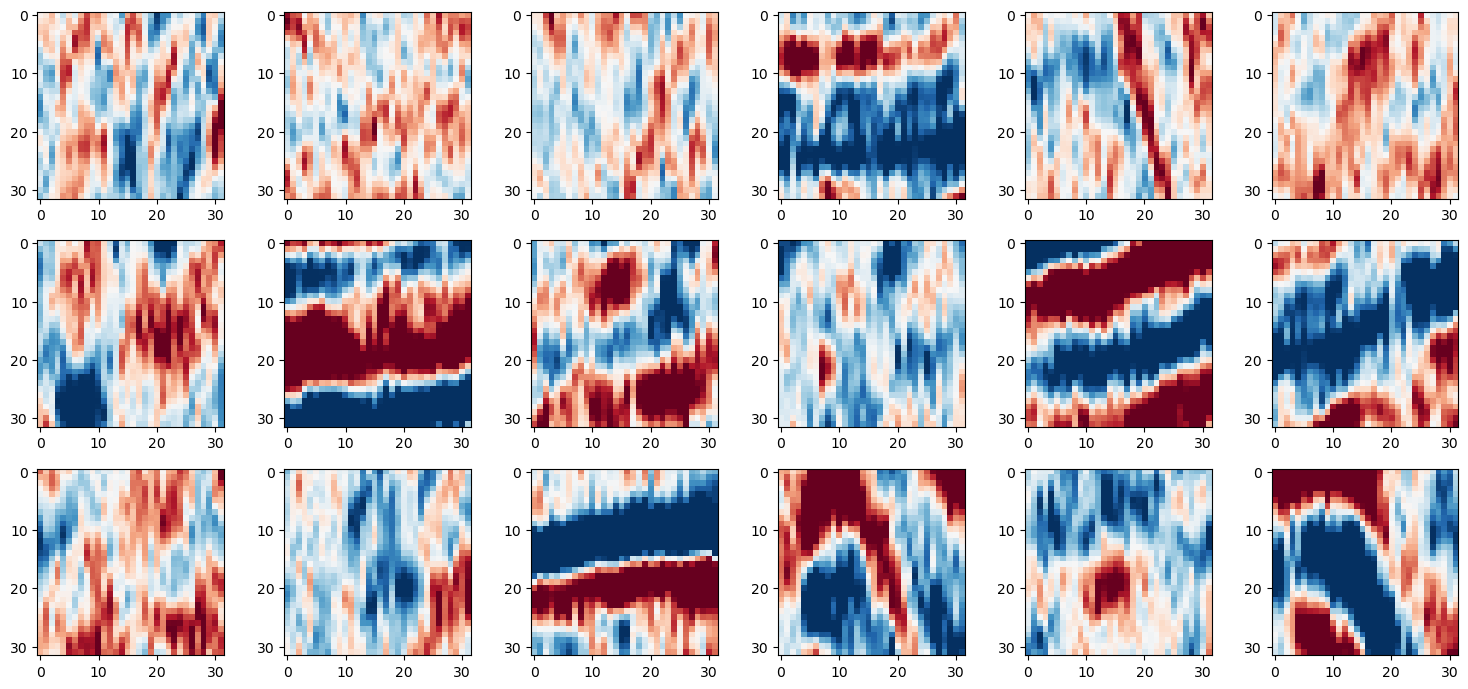

In [5]:
fig, axs = plt.subplots(3,6,figsize=[15,7])
for i in range(6*3):
    axs.ravel()[i].imshow(noisy_patches[i], cmap=cmap, vmin=vmin, vmax=vmax)
fig.tight_layout()

### Blindspot corruption of training data

Now we have made our noisy data into patches such that we have an adequate number to train the network, we now need to pre-process these noisy patches prior to being input into the network. 

Our implementation of the preprocessing involves:

    - selecting the active pixels 
    - selecting the neighbourhood pixel for each active pixel, which it will take the value of
    - replacing each active pixels' value with its neighbourhood pixels' value
    - creating a active pixel 'mask' which shows the location of the active pixels on the patch
    
The first three steps are important for the pre-processing of the noisy patches, whilst the fourth step is required for identifying the locations on which to compute the loss function during training.

#### TO DO:  CHECK THE CORRUPTION FUNCTION WORKS

In [6]:
from ssdn_functions import blind_spot_corruption

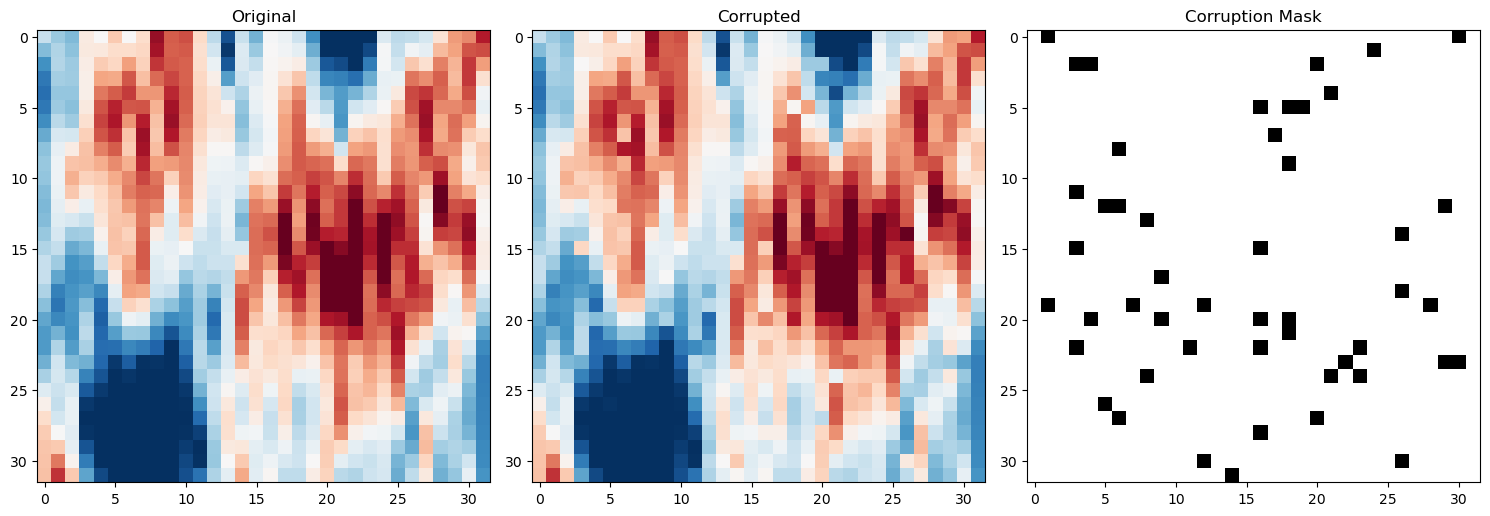

In [7]:
# Input the values of your choice into your pre-processing function
crpt_patch, mask = blind_spot_corruption(noisy_patches[6], 
                                       num_activepixels=50, 
                                       neighbourhood_radius=5, 
                                      )

# Use the pre-made plotting function to visualise the corruption
fig,axs = pu.plot_corruption(noisy_patches[6], crpt_patch, mask)

#### TO DO: SELECT THE NUMBER OF ACTIVE PIXELS (AS PERCENTAGE)

In the original N2V examples the authors use between 0.5 and 2% for the number of active pixels within a patch.

In Birnie et al., 2021 where they use this methodology for the suppression of white, Gaussian noise, the authors use 0.2%. However, in their example they have substantially more training patches.

Number of active pixels selected: 
 2.00 percent equals 20 pixels


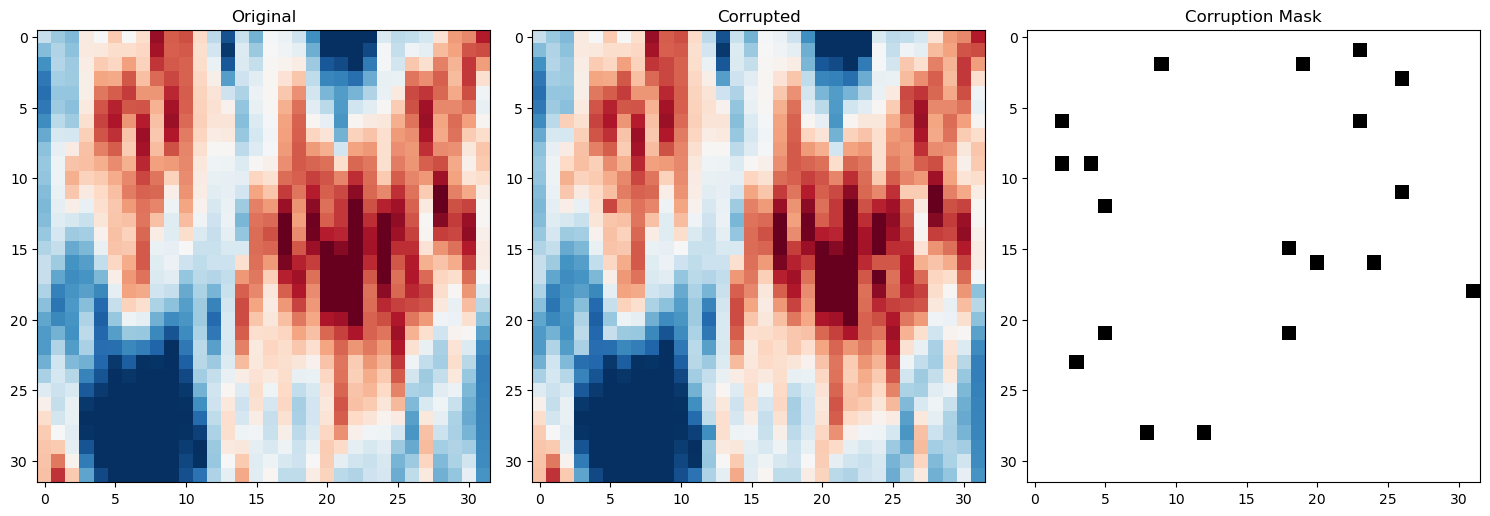

In [8]:
# Choose the percent of active pixels per patch
perc_active = 2
num_activepixels = tu.num_active_pixs(noisy_patches[0].shape, percent_active=perc_active)
neighbourhood_radius = 5

# Input the values of your choice into your pre-processing function
crpt_patch, mask = blind_spot_corruption(noisy_patches[6], 
                                       num_activepixels=num_activepixels, 
                                       neighbourhood_radius=neighbourhood_radius, 
                                      )

# Visulise the coverage of active pixels within a patch
fig,axs = pu.plot_corruption(noisy_patches[6], crpt_patch, mask)

### Set up blind-spot network

In the N2V application of Krull et al., 2018, the network is not specially tailored to the blindspot task. As such, in theory any network could be used that goes from one input image to another of the same size.

In this example, like in Krull et al., 2018 and Birnie et al., 2021's seismic application, we will use a standard UNet architecture. As the architecture is independent to the blind-spot denoising procedure presented, it will be created via functions as opposed to being wrote within the notebook. 

In [9]:
# Select device for training
device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = torch.device(torch.cuda.current_device())
    print(f'Device: {device} {torch.cuda.get_device_name(device)}')
elif torch.backends.mps.is_available(): 
    print("M1 installed! Running on M1!")
    device = torch.device("mps")
else:
    print("No GPU available!")

M1 installed! Running on M1!


#### Build the network

In [10]:
# Build UNet from pre-made function
network = UNet(input_channels=1, 
               output_channels=1, 
               hidden_channels=32,
               levels=2).to(device)
# Initialise UNet's weights from pre-made function
network = network.apply(tu.weights_init) 

#### Select the networks training parameters

In [11]:
lr = 0.0001  # Learning rate
criterion = nn.MSELoss()  # Loss function
optim = torch.optim.Adam(network.parameters(), lr=lr)  # Optimiser

## Blind-spot Network Training

Now we have successfully built our network and prepared our data - by patching it to get adequate training samples and creating the input data by selecting and corrupting the active pixels. We are now ready to train the network.

Remember, the network training is slightly different to standard image processing tasks in that we will only be computing the loss on the active pixels.

#### TO DO: DEFINE TRAINING PARAMETERS

In [12]:
# Choose the number of epochs
n_epochs = 25  # most recommend 150-200 for random noise suppression 

# Choose number of training and validation samples
n_training = 2048
n_test = 512

# Choose the batch size for the networks training
batch_size = 128

In [13]:
# Initialise arrays to keep track of train and validation metrics
train_loss_history = np.zeros(n_epochs)
train_accuracy_history = np.zeros(n_epochs)
test_loss_history = np.zeros(n_epochs)
test_accuracy_history = np.zeros(n_epochs)

# Create torch generator with fixed seed for reproducibility, to be used with the data loaders
g = torch.Generator()
g.manual_seed(0)

#### TO DO: COMPLETE TRAINING LOOP BY INCORPORATING ABOVE FUNCTIONS

In [14]:
from ssdn_functions import n2v_train, n2v_evaluate

In [15]:
# TRAINING
for ep in range(n_epochs):  
        
    # RANDOMLY CORRUPT THE NOISY PATCHES
    corrupted_patches = np.zeros_like(noisy_patches)
    masks = np.zeros_like(corrupted_patches)
    for pi in range(len(noisy_patches)):
        
        # TO DO: USE ACTIVE PIXEL FUNCTION TO COMPUTE INPUT DATA AND MASKS
        # Hint: One line of code
        corrupted_patches[pi], masks[pi] = blind_spot_corruption(noisy_patches[pi], 
                                                               num_activepixels=int(num_activepixels), 
                                                               neighbourhood_radius=neighbourhood_radius, 
                                                              )

    # ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 
    # MAKE DATA LOADERS - using pre-made function 
    train_loader, test_loader = tu.make_data_loader(noisy_patches, 
                                                 corrupted_patches, 
                                                 masks, 
                                                 n_training,
                                                 n_test,
                                                 batch_size = batch_size,
                                                 torch_generator=g
                                                )

    # ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 
    # TRAIN
    # TO DO: Incorporate previously wrote n2v_train function
    train_loss, train_accuracy = n2v_train(network, 
                                           criterion, 
                                           optim, 
                                           train_loader, 
                                           device,)
    # Keeping track of training metrics
    train_loss_history[ep], train_accuracy_history[ep] = train_loss, train_accuracy

    # ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 
    # EVALUATE (AKA VALIDATION)
    # TO DO: Incorporate previously wrote n2v_evaluate function
    test_loss, test_accuracy = n2v_evaluate(network, 
                                            criterion,
                                            optim,
                                            test_loader, 
                                            device,)
    # Keeping track of validation metrics
    test_loss_history[ep], test_accuracy_history[ep] = test_loss, test_accuracy

    # ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 
    # PRINTING TRAINING PROGRESS
    print(f'''Epoch {ep}, 
    Training Loss {train_loss:.4f},     Training Accuracy {train_accuracy:.4f}, 
    Test Loss {test_loss:.4f},     Test Accuracy {test_accuracy:.4f} ''')



100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 16.60it/s]


Epoch 0, 
    Training Loss 0.0004,     Training Accuracy 0.1376, 
    Test Loss 0.0002,     Test Accuracy 0.0859 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 16.19it/s]


Epoch 1, 
    Training Loss 0.0001,     Training Accuracy 0.0764, 
    Test Loss 0.0001,     Test Accuracy 0.0631 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 13.78it/s]


Epoch 2, 
    Training Loss 0.0001,     Training Accuracy 0.0593, 
    Test Loss 0.0001,     Test Accuracy 0.0530 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 15.46it/s]


Epoch 3, 
    Training Loss 0.0001,     Training Accuracy 0.0506, 
    Test Loss 0.0001,     Test Accuracy 0.0464 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 16.02it/s]


Epoch 4, 
    Training Loss 0.0000,     Training Accuracy 0.0450, 
    Test Loss 0.0000,     Test Accuracy 0.0419 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 15.93it/s]


Epoch 5, 
    Training Loss 0.0000,     Training Accuracy 0.0402, 
    Test Loss 0.0000,     Test Accuracy 0.0371 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 15.77it/s]


Epoch 6, 
    Training Loss 0.0000,     Training Accuracy 0.0357, 
    Test Loss 0.0000,     Test Accuracy 0.0332 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 16.45it/s]


Epoch 7, 
    Training Loss 0.0000,     Training Accuracy 0.0321, 
    Test Loss 0.0000,     Test Accuracy 0.0334 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 16.37it/s]


Epoch 8, 
    Training Loss 0.0000,     Training Accuracy 0.0315, 
    Test Loss 0.0000,     Test Accuracy 0.0293 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 16.63it/s]


Epoch 9, 
    Training Loss 0.0000,     Training Accuracy 0.0289, 
    Test Loss 0.0000,     Test Accuracy 0.0276 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 16.42it/s]


Epoch 10, 
    Training Loss 0.0000,     Training Accuracy 0.0272, 
    Test Loss 0.0000,     Test Accuracy 0.0264 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 16.19it/s]


Epoch 11, 
    Training Loss 0.0000,     Training Accuracy 0.0262, 
    Test Loss 0.0000,     Test Accuracy 0.0257 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 16.39it/s]


Epoch 12, 
    Training Loss 0.0000,     Training Accuracy 0.0255, 
    Test Loss 0.0000,     Test Accuracy 0.0251 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 16.18it/s]


Epoch 13, 
    Training Loss 0.0000,     Training Accuracy 0.0252, 
    Test Loss 0.0000,     Test Accuracy 0.0244 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 15.67it/s]


Epoch 14, 
    Training Loss 0.0000,     Training Accuracy 0.0246, 
    Test Loss 0.0000,     Test Accuracy 0.0239 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 14.87it/s]


Epoch 15, 
    Training Loss 0.0000,     Training Accuracy 0.0240, 
    Test Loss 0.0000,     Test Accuracy 0.0232 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 10.48it/s]


Epoch 16, 
    Training Loss 0.0000,     Training Accuracy 0.0233, 
    Test Loss 0.0000,     Test Accuracy 0.0228 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 15.13it/s]


Epoch 17, 
    Training Loss 0.0000,     Training Accuracy 0.0229, 
    Test Loss 0.0000,     Test Accuracy 0.0227 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 15.43it/s]


Epoch 18, 
    Training Loss 0.0000,     Training Accuracy 0.0232, 
    Test Loss 0.0000,     Test Accuracy 0.0227 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 15.40it/s]


Epoch 19, 
    Training Loss 0.0000,     Training Accuracy 0.0223, 
    Test Loss 0.0000,     Test Accuracy 0.0225 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 15.64it/s]


Epoch 20, 
    Training Loss 0.0000,     Training Accuracy 0.0219, 
    Test Loss 0.0000,     Test Accuracy 0.0215 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 16.20it/s]


Epoch 21, 
    Training Loss 0.0000,     Training Accuracy 0.0217, 
    Test Loss 0.0000,     Test Accuracy 0.0212 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 16.17it/s]


Epoch 22, 
    Training Loss 0.0000,     Training Accuracy 0.0216, 
    Test Loss 0.0000,     Test Accuracy 0.0218 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 16.51it/s]


Epoch 23, 
    Training Loss 0.0000,     Training Accuracy 0.0237, 
    Test Loss 0.0000,     Test Accuracy 0.0224 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 16.26it/s]

Epoch 24, 
    Training Loss 0.0000,     Training Accuracy 0.0225, 
    Test Loss 0.0000,     Test Accuracy 0.0221 


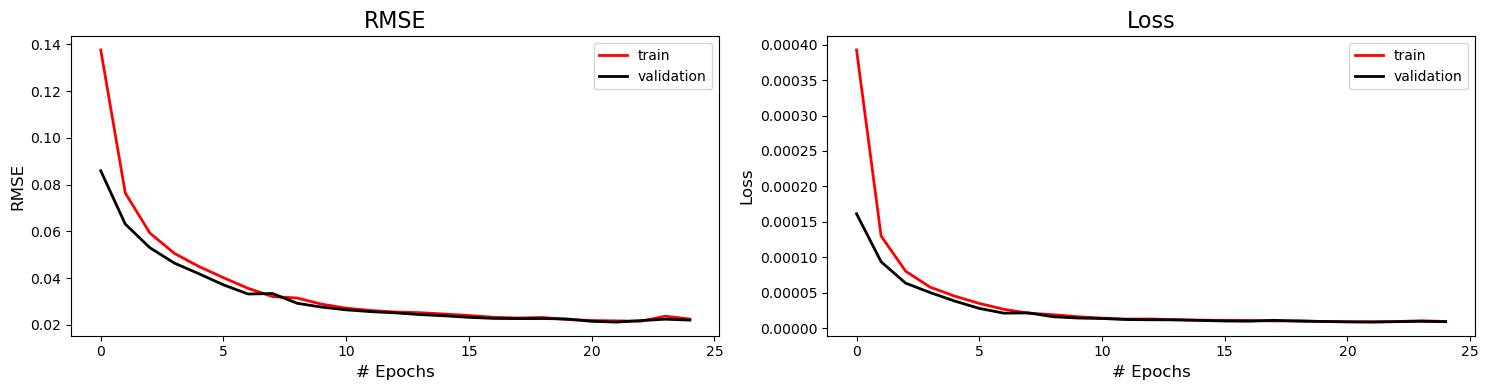

In [16]:
# Plotting trainnig metrics using pre-made function
fig,axs = pu.plot_training_metrics(train_accuracy_history,
                                test_accuracy_history,
                                train_loss_history,
                                test_loss_history
                               )

***

# Run Jacobian Analysis

In [17]:
from ssdn_functions import multi_pix_jacobian_probe

100%|███████████████████████████████████████| 1000/1000 [03:11<00:00,  5.23it/s]


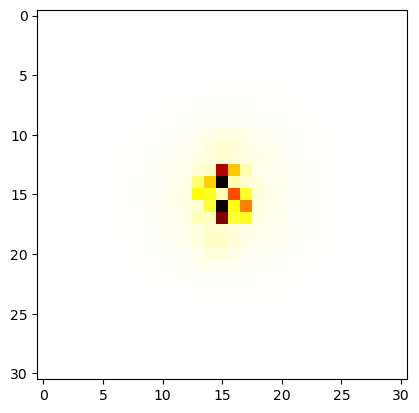

In [18]:
BS_Jacobian_Full = multi_pix_jacobian_probe(network, field_data, numpixs=1000, device=device)
BS_Jacobian_ave = np.mean(abs(BS_Jacobian_Full),axis=0)
plt.imshow(BS_Jacobian_ave, cmap='hot_r', vmin=0, vmax=np.percentile(BS_Jacobian_ave,99.8))

Text(0.5, 1.0, 'Jacobian Mask')

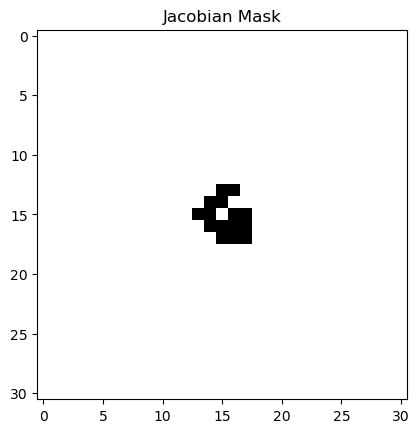

In [19]:
## TO DO: SELECT CONTRIBUTION CUT OFF LIMIT FOR MASK SELECTION
contr_limit = 0.01  # Select Mask Cut-off

# Normalise Jacobian Contributions to sum to 1
norm_pixcontr = BS_Jacobian_ave/np.sum(BS_Jacobian_ave)

# Mask creation and visualisation
jac_mask = np.zeros_like(BS_Jacobian_ave)
jac_mask[np.where(norm_pixcontr>contr_limit)] = 1
plt.imshow(jac_mask, vmin=0, vmax=1, cmap='binary')
plt.title('Jacobian Mask')

----------------------

# BLIND-MASK NETWORK 
## Corrupt using the pre-defined mask

In [20]:
from ssdn_functions import jacobian_corruption

In [21]:
bm_num_activepixels = 10

crpt_patch, crpt_mask, ap_mask = jacobian_corruption(noisy_patches[0],
                                                     jac_mask,
                                                     num_activepixels=int(bm_num_activepixels), 
                                                     crpt_amp = np.mean(abs(noisy_patches[0])),
                                                     )

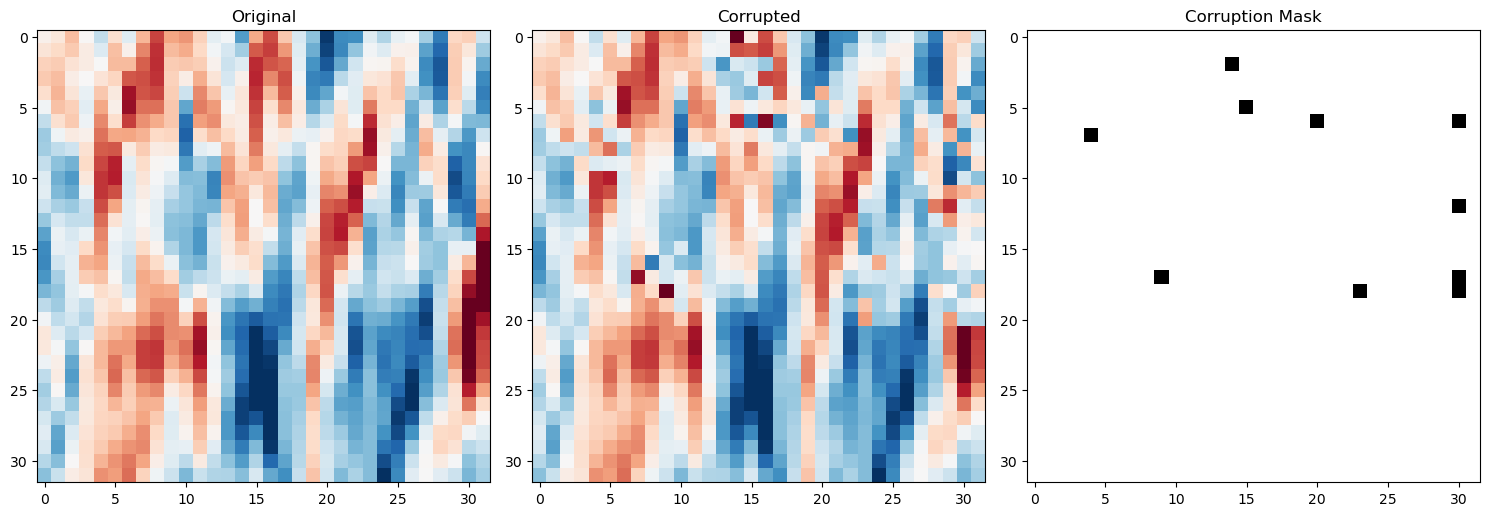

In [22]:
# Use the pre-made plotting function to visualise the corruption
fig,axs = pu.plot_corruption(noisy_patches[0], crpt_patch, ap_mask)

## Make a new network for blind-mask denoising

In [23]:
# Build UNet from pre-made function
bm_network = UNet(input_channels=1, 
               output_channels=1, 
               hidden_channels=32,
               levels=2).to(device)
# Initialise UNet's weights from pre-made function
bm_network = bm_network.apply(tu.weights_init) 

In [24]:
# Blindmask epochs
bm_n_epochs = 100
# reinitiate optimiser
optim = torch.optim.Adam(bm_network.parameters(), lr=lr)  # Optimiser

# Initialise arrays to keep track of train and validation metrics
train_loss_history = np.zeros(bm_n_epochs)
train_accuracy_history = np.zeros(bm_n_epochs)
test_loss_history = np.zeros(bm_n_epochs)
test_accuracy_history = np.zeros(bm_n_epochs)

# Create torch generator with fixed seed for reproducibility, to be used with the data loaders
g = torch.Generator()
g.manual_seed(0)

## Train with automatically generated blind-mask

In [25]:
# TRAINING
for ep in range(bm_n_epochs):          
    # ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 
    # RANDOMLY CORRUPT THE NOISY PATCHES
    corrupted_patches = np.zeros_like(noisy_patches)
    masks = np.zeros_like(corrupted_patches)
    for pi in range(len(noisy_patches)):
        corrupted_patches[pi], _, masks[pi] = jacobian_corruption(noisy_patches[pi], 
                                                                  jac_mask, 
                                                                  num_activepixels=int(num_activepixels), 
                                                                  crpt_amp = np.mean(abs(noisy_patches[pi])),
                                                                  )
        
    # MAKE DATA LOADERS - using pre-made function 
    train_loader, test_loader = tu.make_data_loader(noisy_patches, 
                                                 corrupted_patches, 
                                                 masks, 
                                                 n_training,
                                                 n_test,
                                                 batch_size = batch_size,
                                                 torch_generator=g
                                                )
    
    # ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 
    # TRAIN
    train_loss, train_accuracy = n2v_train(bm_network, 
                                           criterion, 
                                           optim, 
                                           train_loader, 
                                           device,)

    # EVALUATE (AKA VALIDATION)
    test_loss, test_accuracy = n2v_evaluate(bm_network, 
                                            criterion,
                                            optim,
                                            test_loader, 
                                            device,)
    
    
    # Keeping track of training/val metrics for later plots
    train_loss_history[ep], train_accuracy_history[ep] = train_loss, train_accuracy
    test_loss_history[ep], test_accuracy_history[ep] = test_loss, test_accuracy

    # ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 
    # PRINTING TRAINING PROGRESS
    print(f'''Epoch {ep}, 
    Training Loss {train_loss:.4f},     Training Accuracy {train_accuracy:.4f}, 
    Test Loss {test_loss:.4f},     Test Accuracy {test_accuracy:.4f} ''')

100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 15.71it/s]


Epoch 0, 
    Training Loss 0.0006,     Training Accuracy 0.1573, 
    Test Loss 0.0004,     Test Accuracy 0.1365 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 16.06it/s]


Epoch 1, 
    Training Loss 0.0003,     Training Accuracy 0.1222, 
    Test Loss 0.0003,     Test Accuracy 0.1017 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 15.86it/s]


Epoch 2, 
    Training Loss 0.0002,     Training Accuracy 0.1009, 
    Test Loss 0.0002,     Test Accuracy 0.1009 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 15.97it/s]


Epoch 3, 
    Training Loss 0.0002,     Training Accuracy 0.0983, 
    Test Loss 0.0002,     Test Accuracy 0.0973 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 16.16it/s]


Epoch 4, 
    Training Loss 0.0002,     Training Accuracy 0.0954, 
    Test Loss 0.0002,     Test Accuracy 0.0931 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 16.15it/s]


Epoch 5, 
    Training Loss 0.0002,     Training Accuracy 0.0934, 
    Test Loss 0.0002,     Test Accuracy 0.0947 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 16.43it/s]


Epoch 6, 
    Training Loss 0.0002,     Training Accuracy 0.0929, 
    Test Loss 0.0002,     Test Accuracy 0.0931 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 16.35it/s]


Epoch 7, 
    Training Loss 0.0002,     Training Accuracy 0.0916, 
    Test Loss 0.0002,     Test Accuracy 0.0906 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 12.61it/s]


Epoch 8, 
    Training Loss 0.0002,     Training Accuracy 0.0910, 
    Test Loss 0.0002,     Test Accuracy 0.0895 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 15.90it/s]


Epoch 9, 
    Training Loss 0.0002,     Training Accuracy 0.0904, 
    Test Loss 0.0002,     Test Accuracy 0.0881 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 11.28it/s]


Epoch 10, 
    Training Loss 0.0002,     Training Accuracy 0.0912, 
    Test Loss 0.0002,     Test Accuracy 0.0932 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 16.16it/s]


Epoch 11, 
    Training Loss 0.0002,     Training Accuracy 0.0914, 
    Test Loss 0.0002,     Test Accuracy 0.0906 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 16.34it/s]


Epoch 12, 
    Training Loss 0.0002,     Training Accuracy 0.0916, 
    Test Loss 0.0002,     Test Accuracy 0.0902 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 15.98it/s]


Epoch 13, 
    Training Loss 0.0002,     Training Accuracy 0.0899, 
    Test Loss 0.0002,     Test Accuracy 0.0934 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 16.27it/s]


Epoch 14, 
    Training Loss 0.0002,     Training Accuracy 0.0898, 
    Test Loss 0.0002,     Test Accuracy 0.0886 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 16.30it/s]


Epoch 15, 
    Training Loss 0.0002,     Training Accuracy 0.0890, 
    Test Loss 0.0002,     Test Accuracy 0.0899 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 16.22it/s]


Epoch 16, 
    Training Loss 0.0002,     Training Accuracy 0.0894, 
    Test Loss 0.0002,     Test Accuracy 0.0939 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 16.10it/s]


Epoch 17, 
    Training Loss 0.0002,     Training Accuracy 0.0899, 
    Test Loss 0.0002,     Test Accuracy 0.0873 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 15.71it/s]


Epoch 18, 
    Training Loss 0.0002,     Training Accuracy 0.0885, 
    Test Loss 0.0002,     Test Accuracy 0.0869 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 16.43it/s]


Epoch 19, 
    Training Loss 0.0002,     Training Accuracy 0.0880, 
    Test Loss 0.0002,     Test Accuracy 0.0880 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 16.44it/s]


Epoch 20, 
    Training Loss 0.0002,     Training Accuracy 0.0867, 
    Test Loss 0.0001,     Test Accuracy 0.0838 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 16.07it/s]


Epoch 21, 
    Training Loss 0.0001,     Training Accuracy 0.0874, 
    Test Loss 0.0001,     Test Accuracy 0.0859 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 16.11it/s]


Epoch 22, 
    Training Loss 0.0001,     Training Accuracy 0.0868, 
    Test Loss 0.0001,     Test Accuracy 0.0858 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 15.95it/s]


Epoch 23, 
    Training Loss 0.0001,     Training Accuracy 0.0872, 
    Test Loss 0.0001,     Test Accuracy 0.0898 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 16.30it/s]


Epoch 24, 
    Training Loss 0.0001,     Training Accuracy 0.0874, 
    Test Loss 0.0001,     Test Accuracy 0.0914 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 16.13it/s]


Epoch 25, 
    Training Loss 0.0001,     Training Accuracy 0.0880, 
    Test Loss 0.0001,     Test Accuracy 0.0864 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 16.61it/s]


Epoch 26, 
    Training Loss 0.0001,     Training Accuracy 0.0865, 
    Test Loss 0.0001,     Test Accuracy 0.0852 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 16.32it/s]


Epoch 27, 
    Training Loss 0.0001,     Training Accuracy 0.0869, 
    Test Loss 0.0001,     Test Accuracy 0.0850 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 16.16it/s]


Epoch 28, 
    Training Loss 0.0001,     Training Accuracy 0.0868, 
    Test Loss 0.0001,     Test Accuracy 0.0848 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 16.32it/s]


Epoch 29, 
    Training Loss 0.0001,     Training Accuracy 0.0859, 
    Test Loss 0.0001,     Test Accuracy 0.0836 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 16.07it/s]


Epoch 30, 
    Training Loss 0.0001,     Training Accuracy 0.0857, 
    Test Loss 0.0001,     Test Accuracy 0.0848 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 16.20it/s]


Epoch 31, 
    Training Loss 0.0001,     Training Accuracy 0.0876, 
    Test Loss 0.0001,     Test Accuracy 0.0863 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 16.22it/s]


Epoch 32, 
    Training Loss 0.0001,     Training Accuracy 0.0854, 
    Test Loss 0.0001,     Test Accuracy 0.0839 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 15.97it/s]


Epoch 33, 
    Training Loss 0.0001,     Training Accuracy 0.0844, 
    Test Loss 0.0001,     Test Accuracy 0.0851 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 16.28it/s]


Epoch 34, 
    Training Loss 0.0001,     Training Accuracy 0.0850, 
    Test Loss 0.0001,     Test Accuracy 0.0843 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 16.10it/s]


Epoch 35, 
    Training Loss 0.0001,     Training Accuracy 0.0855, 
    Test Loss 0.0001,     Test Accuracy 0.0813 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 16.35it/s]


Epoch 36, 
    Training Loss 0.0001,     Training Accuracy 0.0847, 
    Test Loss 0.0001,     Test Accuracy 0.0825 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 16.52it/s]


Epoch 37, 
    Training Loss 0.0001,     Training Accuracy 0.0836, 
    Test Loss 0.0001,     Test Accuracy 0.0832 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 15.69it/s]


Epoch 38, 
    Training Loss 0.0001,     Training Accuracy 0.0838, 
    Test Loss 0.0001,     Test Accuracy 0.0821 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 16.15it/s]


Epoch 39, 
    Training Loss 0.0001,     Training Accuracy 0.0836, 
    Test Loss 0.0001,     Test Accuracy 0.0841 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 16.46it/s]


Epoch 40, 
    Training Loss 0.0001,     Training Accuracy 0.0828, 
    Test Loss 0.0001,     Test Accuracy 0.0830 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 16.27it/s]


Epoch 41, 
    Training Loss 0.0001,     Training Accuracy 0.0836, 
    Test Loss 0.0001,     Test Accuracy 0.0828 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 16.35it/s]


Epoch 42, 
    Training Loss 0.0001,     Training Accuracy 0.0832, 
    Test Loss 0.0001,     Test Accuracy 0.0801 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 16.22it/s]


Epoch 43, 
    Training Loss 0.0001,     Training Accuracy 0.0822, 
    Test Loss 0.0001,     Test Accuracy 0.0817 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 16.22it/s]


Epoch 44, 
    Training Loss 0.0001,     Training Accuracy 0.0823, 
    Test Loss 0.0001,     Test Accuracy 0.0827 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 16.41it/s]


Epoch 45, 
    Training Loss 0.0001,     Training Accuracy 0.0826, 
    Test Loss 0.0001,     Test Accuracy 0.0811 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 15.81it/s]


Epoch 46, 
    Training Loss 0.0001,     Training Accuracy 0.0814, 
    Test Loss 0.0001,     Test Accuracy 0.0791 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 16.01it/s]


Epoch 47, 
    Training Loss 0.0001,     Training Accuracy 0.0816, 
    Test Loss 0.0001,     Test Accuracy 0.0801 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 16.14it/s]


Epoch 48, 
    Training Loss 0.0001,     Training Accuracy 0.0811, 
    Test Loss 0.0001,     Test Accuracy 0.0842 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 16.33it/s]


Epoch 49, 
    Training Loss 0.0001,     Training Accuracy 0.0817, 
    Test Loss 0.0001,     Test Accuracy 0.0812 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 16.02it/s]


Epoch 50, 
    Training Loss 0.0001,     Training Accuracy 0.0810, 
    Test Loss 0.0001,     Test Accuracy 0.0824 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 16.12it/s]


Epoch 51, 
    Training Loss 0.0001,     Training Accuracy 0.0821, 
    Test Loss 0.0001,     Test Accuracy 0.0813 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 16.00it/s]


Epoch 52, 
    Training Loss 0.0001,     Training Accuracy 0.0807, 
    Test Loss 0.0001,     Test Accuracy 0.0831 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 15.92it/s]


Epoch 53, 
    Training Loss 0.0001,     Training Accuracy 0.0811, 
    Test Loss 0.0001,     Test Accuracy 0.0781 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 16.29it/s]


Epoch 54, 
    Training Loss 0.0001,     Training Accuracy 0.0801, 
    Test Loss 0.0001,     Test Accuracy 0.0794 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 16.01it/s]


Epoch 55, 
    Training Loss 0.0001,     Training Accuracy 0.0807, 
    Test Loss 0.0001,     Test Accuracy 0.0815 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 15.82it/s]


Epoch 56, 
    Training Loss 0.0001,     Training Accuracy 0.0804, 
    Test Loss 0.0001,     Test Accuracy 0.0772 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 16.04it/s]


Epoch 57, 
    Training Loss 0.0001,     Training Accuracy 0.0786, 
    Test Loss 0.0001,     Test Accuracy 0.0780 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 15.31it/s]


Epoch 58, 
    Training Loss 0.0001,     Training Accuracy 0.0791, 
    Test Loss 0.0001,     Test Accuracy 0.0770 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 15.39it/s]


Epoch 59, 
    Training Loss 0.0001,     Training Accuracy 0.0780, 
    Test Loss 0.0001,     Test Accuracy 0.0804 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 12.40it/s]


Epoch 60, 
    Training Loss 0.0001,     Training Accuracy 0.0792, 
    Test Loss 0.0001,     Test Accuracy 0.0794 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 16.31it/s]


Epoch 61, 
    Training Loss 0.0001,     Training Accuracy 0.0789, 
    Test Loss 0.0001,     Test Accuracy 0.0777 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 16.20it/s]


Epoch 62, 
    Training Loss 0.0001,     Training Accuracy 0.0782, 
    Test Loss 0.0001,     Test Accuracy 0.0762 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 15.68it/s]


Epoch 63, 
    Training Loss 0.0001,     Training Accuracy 0.0780, 
    Test Loss 0.0001,     Test Accuracy 0.0763 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 15.88it/s]


Epoch 64, 
    Training Loss 0.0001,     Training Accuracy 0.0781, 
    Test Loss 0.0001,     Test Accuracy 0.0765 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 16.53it/s]


Epoch 65, 
    Training Loss 0.0001,     Training Accuracy 0.0776, 
    Test Loss 0.0001,     Test Accuracy 0.0775 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 16.62it/s]


Epoch 66, 
    Training Loss 0.0001,     Training Accuracy 0.0779, 
    Test Loss 0.0001,     Test Accuracy 0.0771 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 15.75it/s]


Epoch 67, 
    Training Loss 0.0001,     Training Accuracy 0.0776, 
    Test Loss 0.0001,     Test Accuracy 0.0776 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 15.90it/s]


Epoch 68, 
    Training Loss 0.0001,     Training Accuracy 0.0771, 
    Test Loss 0.0001,     Test Accuracy 0.0780 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 16.28it/s]


Epoch 69, 
    Training Loss 0.0001,     Training Accuracy 0.0777, 
    Test Loss 0.0001,     Test Accuracy 0.0754 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 15.50it/s]


Epoch 70, 
    Training Loss 0.0001,     Training Accuracy 0.0768, 
    Test Loss 0.0001,     Test Accuracy 0.0776 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 16.33it/s]


Epoch 71, 
    Training Loss 0.0001,     Training Accuracy 0.0783, 
    Test Loss 0.0001,     Test Accuracy 0.0773 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 16.13it/s]


Epoch 72, 
    Training Loss 0.0001,     Training Accuracy 0.0771, 
    Test Loss 0.0001,     Test Accuracy 0.0776 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 16.11it/s]


Epoch 73, 
    Training Loss 0.0001,     Training Accuracy 0.0772, 
    Test Loss 0.0001,     Test Accuracy 0.0783 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 16.14it/s]


Epoch 74, 
    Training Loss 0.0001,     Training Accuracy 0.0766, 
    Test Loss 0.0001,     Test Accuracy 0.0755 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 15.69it/s]


Epoch 75, 
    Training Loss 0.0001,     Training Accuracy 0.0759, 
    Test Loss 0.0001,     Test Accuracy 0.0752 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 16.11it/s]


Epoch 76, 
    Training Loss 0.0001,     Training Accuracy 0.0771, 
    Test Loss 0.0001,     Test Accuracy 0.0752 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 16.00it/s]


Epoch 77, 
    Training Loss 0.0001,     Training Accuracy 0.0763, 
    Test Loss 0.0001,     Test Accuracy 0.0753 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 15.43it/s]


Epoch 78, 
    Training Loss 0.0001,     Training Accuracy 0.0757, 
    Test Loss 0.0001,     Test Accuracy 0.0753 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 11.33it/s]


Epoch 79, 
    Training Loss 0.0001,     Training Accuracy 0.0755, 
    Test Loss 0.0001,     Test Accuracy 0.0751 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 14.31it/s]


Epoch 80, 
    Training Loss 0.0001,     Training Accuracy 0.0757, 
    Test Loss 0.0001,     Test Accuracy 0.0755 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 15.75it/s]


Epoch 81, 
    Training Loss 0.0001,     Training Accuracy 0.0756, 
    Test Loss 0.0001,     Test Accuracy 0.0770 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 16.19it/s]


Epoch 82, 
    Training Loss 0.0001,     Training Accuracy 0.0764, 
    Test Loss 0.0001,     Test Accuracy 0.0741 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 15.31it/s]


Epoch 83, 
    Training Loss 0.0001,     Training Accuracy 0.0762, 
    Test Loss 0.0001,     Test Accuracy 0.0785 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 15.97it/s]


Epoch 84, 
    Training Loss 0.0001,     Training Accuracy 0.0762, 
    Test Loss 0.0001,     Test Accuracy 0.0749 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 16.41it/s]


Epoch 85, 
    Training Loss 0.0001,     Training Accuracy 0.0760, 
    Test Loss 0.0001,     Test Accuracy 0.0756 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 14.73it/s]


Epoch 86, 
    Training Loss 0.0001,     Training Accuracy 0.0760, 
    Test Loss 0.0001,     Test Accuracy 0.0739 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 14.84it/s]


Epoch 87, 
    Training Loss 0.0001,     Training Accuracy 0.0747, 
    Test Loss 0.0001,     Test Accuracy 0.0763 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 15.58it/s]


Epoch 88, 
    Training Loss 0.0001,     Training Accuracy 0.0751, 
    Test Loss 0.0001,     Test Accuracy 0.0748 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 15.70it/s]


Epoch 89, 
    Training Loss 0.0001,     Training Accuracy 0.0755, 
    Test Loss 0.0001,     Test Accuracy 0.0737 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  7.67it/s]


Epoch 90, 
    Training Loss 0.0001,     Training Accuracy 0.0750, 
    Test Loss 0.0001,     Test Accuracy 0.0739 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 16.38it/s]


Epoch 91, 
    Training Loss 0.0001,     Training Accuracy 0.0743, 
    Test Loss 0.0001,     Test Accuracy 0.0756 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 14.56it/s]


Epoch 92, 
    Training Loss 0.0001,     Training Accuracy 0.0745, 
    Test Loss 0.0001,     Test Accuracy 0.0739 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 15.97it/s]


Epoch 93, 
    Training Loss 0.0001,     Training Accuracy 0.0741, 
    Test Loss 0.0001,     Test Accuracy 0.0732 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 15.44it/s]


Epoch 94, 
    Training Loss 0.0001,     Training Accuracy 0.0750, 
    Test Loss 0.0001,     Test Accuracy 0.0755 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 15.97it/s]


Epoch 95, 
    Training Loss 0.0001,     Training Accuracy 0.0742, 
    Test Loss 0.0001,     Test Accuracy 0.0750 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 14.51it/s]


Epoch 96, 
    Training Loss 0.0001,     Training Accuracy 0.0742, 
    Test Loss 0.0001,     Test Accuracy 0.0751 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 15.11it/s]


Epoch 97, 
    Training Loss 0.0001,     Training Accuracy 0.0744, 
    Test Loss 0.0001,     Test Accuracy 0.0756 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  9.23it/s]


Epoch 98, 
    Training Loss 0.0001,     Training Accuracy 0.0750, 
    Test Loss 0.0001,     Test Accuracy 0.0750 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 15.33it/s]

Epoch 99, 
    Training Loss 0.0001,     Training Accuracy 0.0744, 
    Test Loss 0.0001,     Test Accuracy 0.0723 


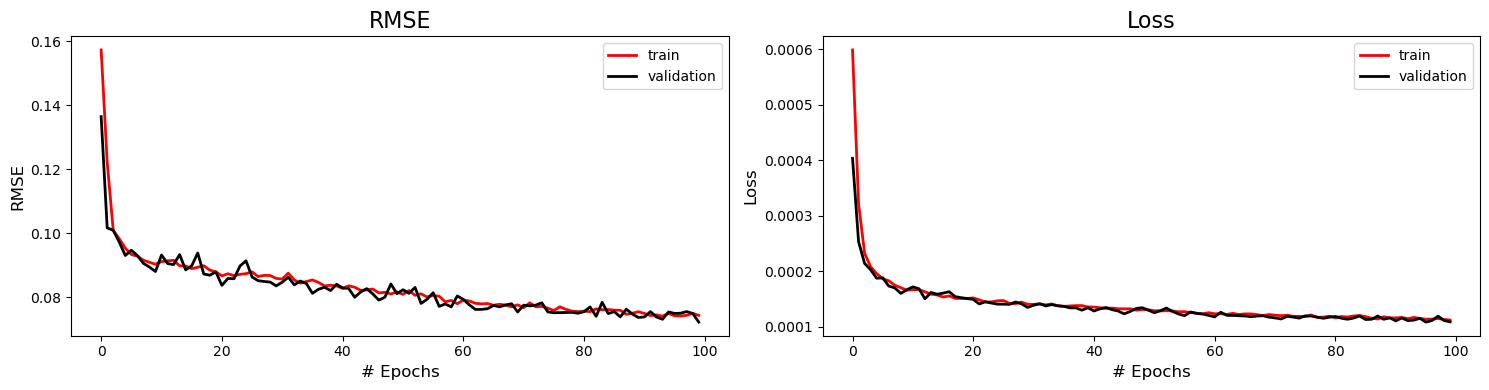

In [26]:
# Plotting training metrics using pre-made function
fig,axs = pu.plot_training_metrics(train_accuracy_history,
                                test_accuracy_history,
                                train_loss_history,
                                test_loss_history
                               )

------------------------

# Apply trained blind-mask network

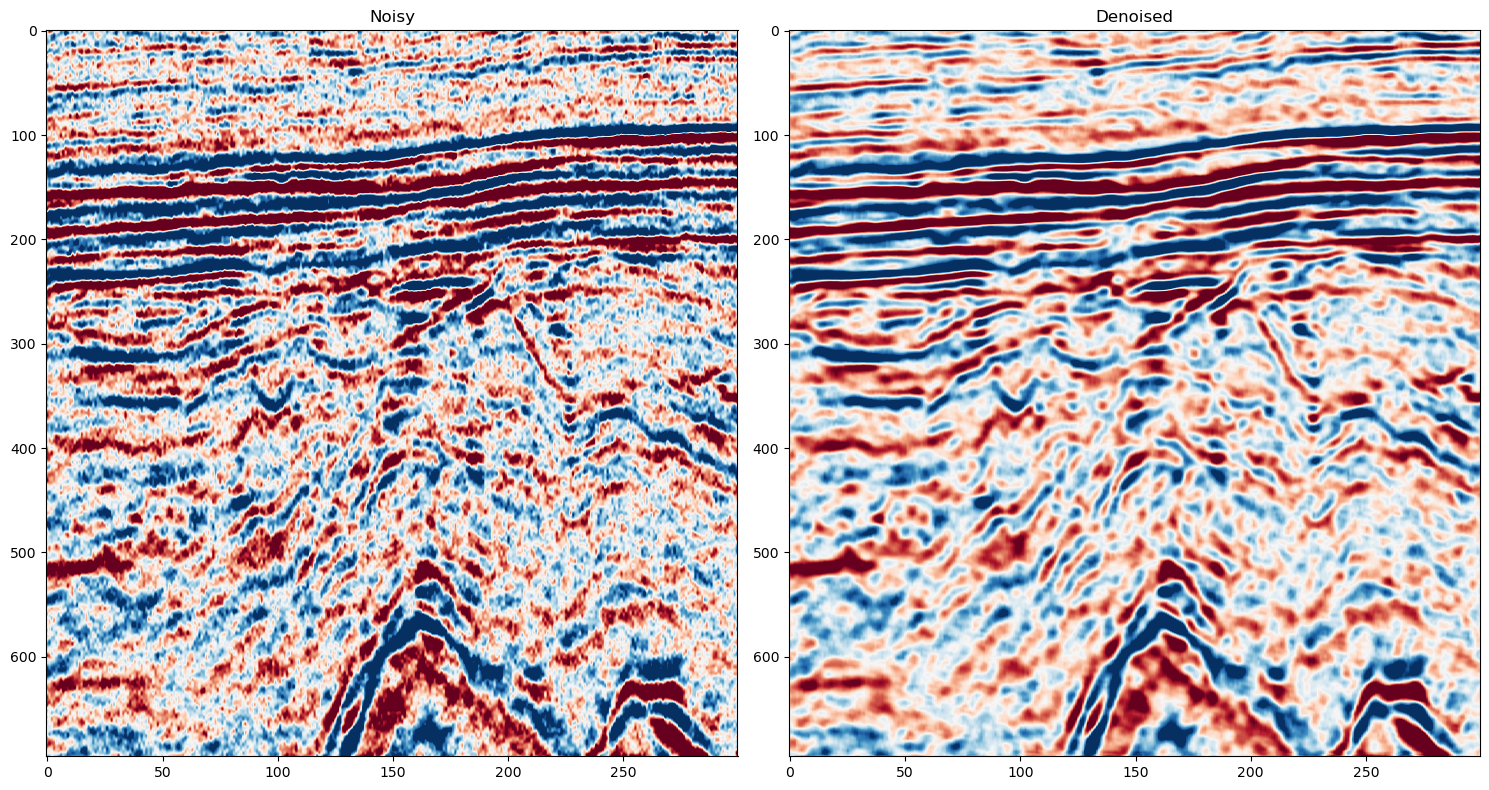

In [27]:
# Convert field dataset to tensor for prediction purposes
torch_testdata = torch.from_numpy(np.expand_dims(np.expand_dims(field_data,axis=0),axis=0)).float()

# Run test dataset through network
bm_network.eval()
test_prediction = bm_network(torch_testdata.to(device))

# Return to numpy for plotting purposes
test_pred = test_prediction.detach().cpu().numpy().squeeze()

# Use pre-made plotting function to visualise denoising performance
fig, axs = pu.plot_field_results(field_data, test_pred)

---------------

# Last Task: Compare results
This dataset is commonly used for benchmarking random noise suppression procedures. Go back to tutorial two where we implemented N2V on this dataset and compare the results between a blind-spot and a blind-mask procedure.